In [ ]:
! pip install segmentation_models_pytorch

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import random
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import torchvision.transforms.functional as tf
import rasterio


# for the tiff things https://discuss.pytorch.org/t/training-a-cnn-with-tiff-images-in-pytorch/9531/4

In [ ]:
fpn = smp.FPN(encoder_weights='imagenet', in_channels=4,classes=1,activation='sigmoid')
fpn.eval()

FPN(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [ ]:
# based on https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        #self.img_labels = annotations
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith('.tif')] # instead of the annotations from the other dataset, from claude

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        mask_path = os.path.join(self.mask_dir, self.img_files[idx])

        with rasterio.open(img_path) as src:
            image = src.read()
            image = np.transpose(image, (1, 2, 0)) # changing the channel order, needed
            image = image.astype(np.float32) / 10000.0 # sentinel uses 0-10000 values for each pixel, normalization

        with rasterio.open(mask_path) as src:
            label = src.read(1).astype(np.float32)


        if self.transform:
            image, label = self.transform(image, label)

        return image, label

In [ ]:
#mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# 1. Ścieżki (Dostosuj jeśli trzeba)
src_folder = '/content/drive/MyDrive/ATLANTIC FOREST'
dest_folder = '/content/local_atlantic_data'

# 2. Tworzenie folderu docelowego
!mkdir -p {dest_folder}

# 3. Kopiowanie z wypisywaniem każdego pliku (-v)
# Flaga -r kopiuje foldery, -v wypisuje nazwy plików
print("Rozpoczynam kopiowanie... Zaraz zobaczysz listę plików.")
!cp -rv "{src_folder}/." "{dest_folder}"

print("\n✅ Kopiowanie zakończone!")

Rozpoczynam kopiowanie... Zaraz zobaczysz listę plików.
'/content/drive/MyDrive/AMAZON/./.DS_Store' -> '/content/local_amazon_data/./.DS_Store'
'/content/drive/MyDrive/AMAZON/./Validation' -> '/content/local_amazon_data/./Validation'
'/content/drive/MyDrive/AMAZON/./Validation/.DS_Store' -> '/content/local_amazon_data/./Validation/.DS_Store'
'/content/drive/MyDrive/AMAZON/./Validation/images' -> '/content/local_amazon_data/./Validation/images'
'/content/drive/MyDrive/AMAZON/./Validation/images/S2A_MSIL2A_20200111T142701_N0213_R053_T20NQG_20200111T164651_01_04.tif' -> '/content/local_amazon_data/./Validation/images/S2A_MSIL2A_20200111T142701_N0213_R053_T20NQG_20200111T164651_01_04.tif'
'/content/drive/MyDrive/AMAZON/./Validation/images/S2A_MSIL2A_20200111T142701_N0213_R053_T20NQG_20200111T164651_01_05.tif' -> '/content/local_amazon_data/./Validation/images/S2A_MSIL2A_20200111T142701_N0213_R053_T20NQG_20200111T164651_01_05.tif'
'/content/drive/MyDrive/AMAZON/./Validation/images/S2A_MSIL2

In [ ]:
# RANDOM ASS SHIT
def random_transforms(img,mask):
  img = tf.to_tensor(img)
  mask = tf.to_tensor(mask)

  r = random.random()
  if r > 0.5:
    pass
  elif r > 0.25:
    img = tf.hflip(img)
    mask = tf.hflip(mask)
  else:
    img = tf.vflip(img)
    mask = tf.vflip(mask)

  angles = [0, 90, 180, 270]
  angle = random.choice(angles)
  img = tf.rotate(img, angle)
  mask = tf.rotate(mask, angle)

  return img, mask

# NO TRANSFORMSSSSS
def val_transforms(img, mask):
  img = tf.to_tensor(img)
  mask = tf.to_tensor(mask)
  return img, mask


In [ ]:
train_img_path = '/content/local_amazon_data/Training/image'
train_mask_path = '/content/local_amazon_data/Training/label'

val_img_path = '/content/local_amazon_data/Validation/images'
val_mask_path = '/content/local_amazon_data/Validation/masks'

In [ ]:
train = CustomImageDataset(train_img_path,train_mask_path,random_transforms)
val = CustomImageDataset(val_img_path,val_mask_path,val_transforms)

train_dataloader = DataLoader(train, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val, batch_size=8, shuffle=True)

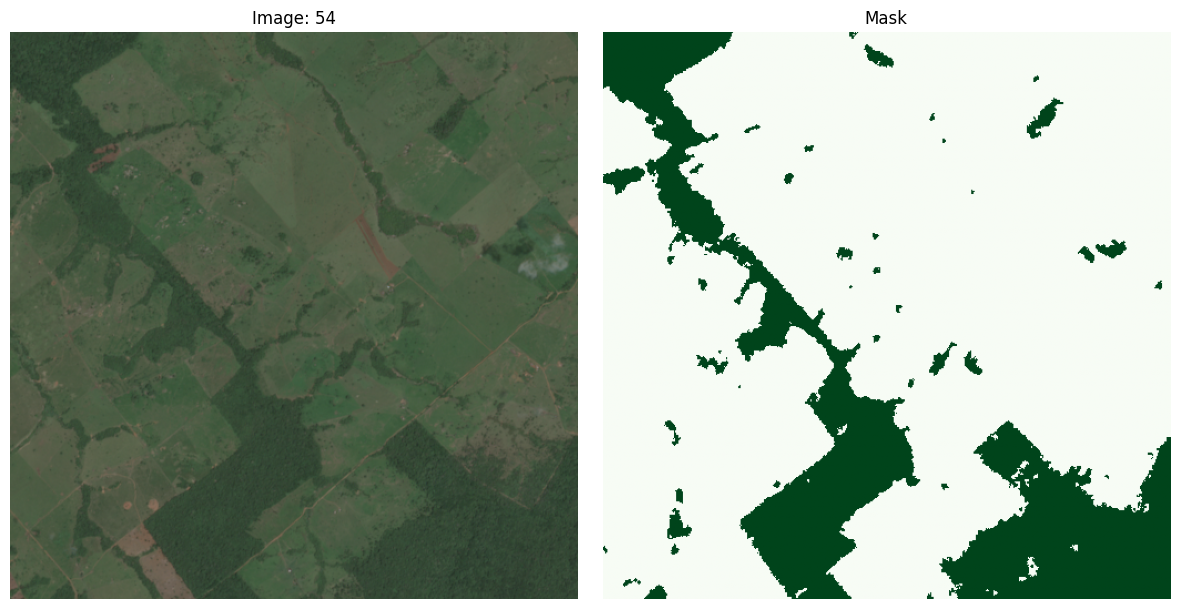

In [ ]:
# stolen from rocco
def visualize_random_sample(dataset):
    # visualize random sample
    idx = random.randint(0, len(dataset) - 1)
    image, mask = dataset[idx]

    img_plot = image[:3, :, :].permute(1, 2, 0).numpy() # only 3 channels rgb
    img_plot = np.clip(img_plot, 0, 1)
    img_plot = np.power(img_plot, 0.4) # boost brightmess, after normalization plot gets dim
    mask_plot = mask.squeeze().numpy()

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(img_plot)
    plt.title(f"Image: {idx}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_plot, cmap='Greens') # 'Greens' o 'gray' para ver el contraste
    plt.title("Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_random_sample(val)

In [ ]:
#choose device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

if device.type == 'cuda':
    print(f"Device name: {torch.cuda.get_device_name(0)}")

model = fpn
model.to(device)

criterion = smp.losses.DiceLoss(mode='binary') #loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=5)

num_epochs = 20
best_loss = np.inf
best_model_params_path = 'best_model.pth'

train_losses = []
val_losses = []

# based on https://docs.pytorch.org/tutorials/beginner/transfer_learning_tutorial.html adjusted for segmentation
for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                    dataloader = train_dataloader
                else:
                    model.eval()   # Set model to evaluate mode
                    dataloader = val_dataloader

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        #preds = (outputs > 0.5).float()
                        loss = criterion(outputs, labels)


                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / len(dataloader.dataset)

                print(f'{phase} Loss: {epoch_loss:.4f}\n')

                if phase == 'train':
                    train_losses.append(epoch_loss)
                else:
                    val_losses.append(epoch_loss)

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

Using device: cuda
Device name: Tesla T4
Epoch 1/20
----------
train Loss: 0.3680

val Loss: 0.3545

Epoch 2/20
----------
train Loss: 0.3564

val Loss: 0.3585

Epoch 3/20
----------
train Loss: 0.3524

val Loss: 0.3537

Epoch 4/20
----------
train Loss: 0.3456

val Loss: 0.3490

Epoch 5/20
----------
train Loss: 0.3470

val Loss: 0.3454

Epoch 6/20
----------
train Loss: 0.3458

val Loss: 0.3556

Epoch 7/20
----------
train Loss: 0.3437

val Loss: 0.3471

Epoch 8/20
----------
train Loss: 0.3450

val Loss: 0.3469

Epoch 9/20
----------
train Loss: 0.3448

val Loss: 0.3459

Epoch 10/20
----------
train Loss: 0.3442

val Loss: 0.3556

Epoch 11/20
----------
train Loss: 0.3439

val Loss: 0.3511

Epoch 12/20
----------
train Loss: 0.3451

val Loss: 0.3505

Epoch 13/20
----------
train Loss: 0.3434

val Loss: 0.3529

Epoch 14/20
----------
train Loss: 0.3459

val Loss: 0.3483

Epoch 15/20
----------
train Loss: 0.3441

val Loss: 0.3478

Epoch 16/20
----------
train Loss: 0.3426

val Loss: 

In [ ]:
! ls

best_model.pth	drive  local_amazon_data  sample_data


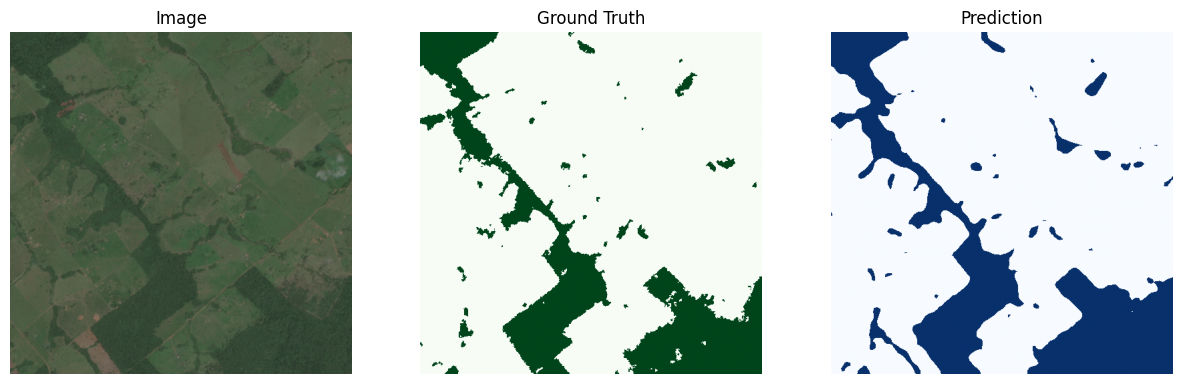

In [ ]:
# yoink
def test_prediction(dataset, model, device):
    model.eval()
    idx = random.randint(0, len(dataset) - 1)
    image, mask = dataset[idx]

    # Preparar imagen para el modelo (añadir dimensión de batch)
    input_img = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_img)
        # Convertir probabilidad a máscara binaria (umbral 0.5)
        pred_mask = (output > 0.5).float().cpu().squeeze().numpy()

    # Preparar para graficar
    img_plot = image[:3, :, :].permute(1, 2, 0).numpy() # only 3 channels rgb
    img_plot = np.clip(img_plot, 0, 1)
    img_plot = np.power(img_plot, 0.4) # boost brightmess, after normalization plot gets dim
    true_mask = mask.squeeze().numpy()

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img_plot)
    plt.title("Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='Greens')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='Blues')
    plt.title("Prediction")
    plt.axis('off')

    plt.show()

# Cargar el mejor modelo antes de probar
model.load_state_dict(torch.load('best_model.pth'))
test_prediction(val, model, device)

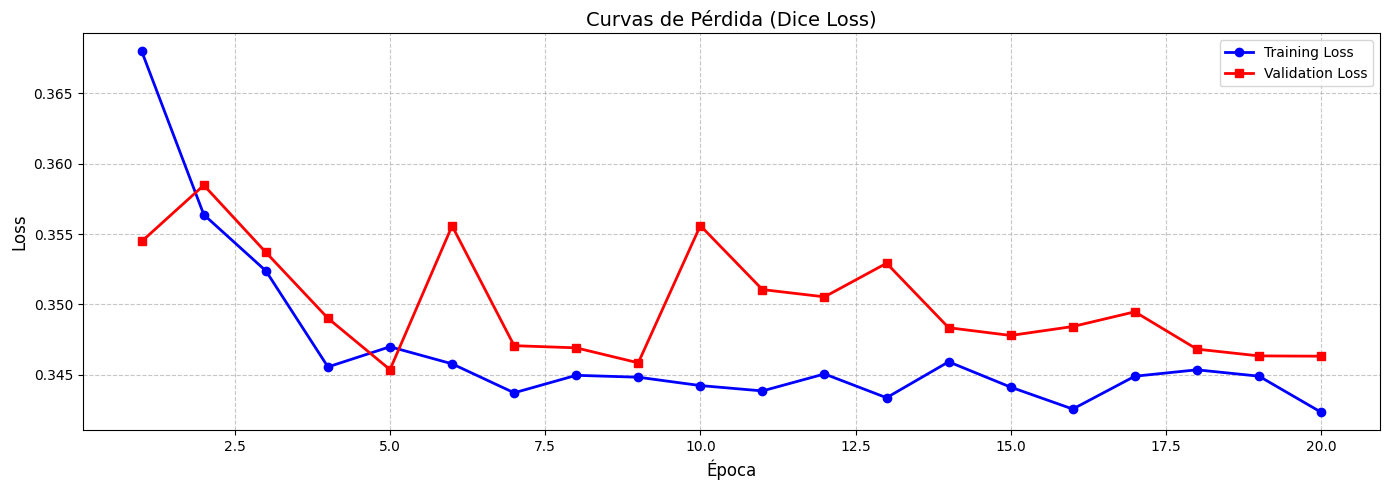

In [ ]:
# again

# --- DATOS EXTRAÍDOS DE TUS LOGS ---
epochs = list(range(1, 21))

# --- CREACIÓN DEL GRÁFICO ---
plt.figure(figsize=(14, 5))

# Curvas de Pérdida (Loss)
plt.plot(epochs, train_losses, 'b-o', label='Training Loss', linewidth=2)
plt.plot(epochs, val_losses, 'r-s', label='Validation Loss', linewidth=2)
plt.title('Curvas de Pérdida (Dice Loss)', fontsize=14)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.savefig('reporte_entrenamiento_unet.png', dpi=300) # Guarda el gráfico en alta calidad
plt.show()